## Goal: how does transcript length affect # and type of transcript detection?

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import yaml
from snakemake.io import expand
import pyranges as pr
from pyfaidx import Fasta
from mizani.formatters import percent_format
from scipy import stats


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

from plotnine import *

In [2]:
def my_theme(base_size=11, w=4, h=3):
    """
    Custom plotnine theme with:
    - White background
    - Clean styling
    - Axes and ticks retained

    Parameters:
    - base_size: Base font size

    Returns:
    - plotnine.theme object
    """
    return (
        theme_minimal(base_size=base_size)
        + theme(
            # White background
            panel_background=element_rect(fill='white', color=None),
            plot_background=element_rect(fill='white', color=None),

            # Remove grid lines
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),

            # Keep axis lines & ticks (don't blank them)
            axis_line=element_line(color='black'),
            axis_ticks=element_line(color='black'),

            plot_title=element_text(hjust=0.5, family='Helvetica'),
            axis_title_x=element_text(hjust=0.5, family='Helvetica'),
            axis_title_y=element_text(hjust=0.5, margin={'t':0, 'r':-2, 'b':0, 'l':0}, family='Helvetica'),
            
            # Styling text
            legend_title=element_blank(),
            axis_title=element_text(size=base_size + 1, family='Helvetica'),
            legend_text=element_text(size=base_size-2, family='Helvetica'),
            axis_text=element_text(size=base_size, color='black', family='Helvetica'),
            figure_size=(w, h),  # Controls plot dimensions (width x height in inches)
            plot_margin=0.05      # Shrinks surrounding white space
        )
    )

def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

In [3]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [4]:
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table_fixed_genics.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)
mt_df['det_pop'] = mt_df[get_population_colors()[1]].idxmax(axis=1)

In [5]:
mt_df[['isoform', 'geneid.v', 'length']].sort_values(by='geneid.v').head()

,isoform,geneid.v,length
153461,transcript_375466,ENSG00000000003.16,3768
151322,transcript_184187,ENSG00000000005.6,1205
95906,transcript_306721,ENSG00000000419.14,959
95912,transcript_306737,ENSG00000000419.14,1097
95911,transcript_306736,ENSG00000000419.14,1290


## First, general distributions

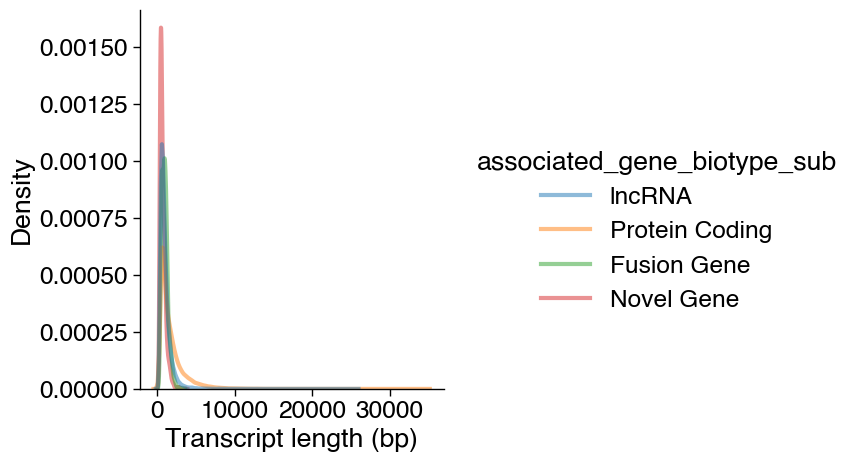

In [6]:
# biotype
temp = mt_df[['length', 'isoform', 'associated_gene_biotype_sub']].drop_duplicates()
init_plot_settings()
ax = sns.displot(temp,
                 x='length', kind='kde',
                 hue='associated_gene_biotype_sub',
                 linewidth=3, common_norm=False, alpha=0.5)
ax.set(xlabel='Transcript length (bp)')

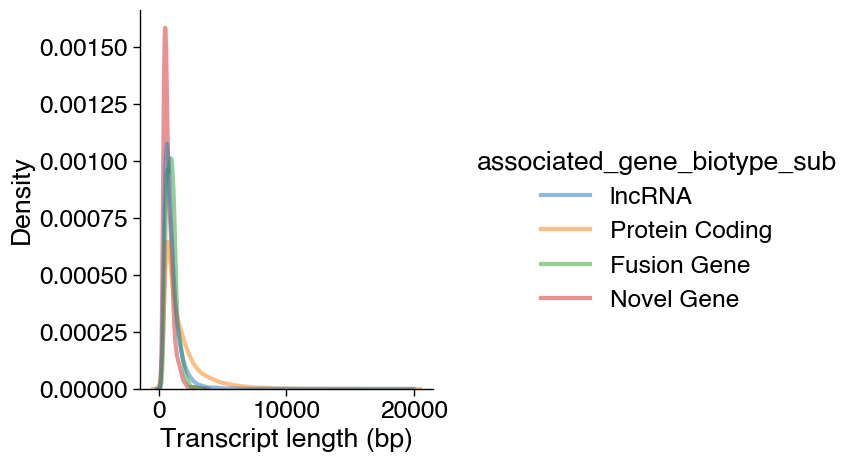

In [7]:
temp = mt_df[['length', 'isoform', 'associated_gene_biotype_sub']].drop_duplicates()
temp = temp.loc[temp.length<20000]
init_plot_settings()
ax = sns.displot(temp,
                 x='length', kind='kde',
                 hue='associated_gene_biotype_sub',
                 linewidth=3, common_norm=False, alpha=0.5)
ax.set(xlabel='Transcript length (bp)')


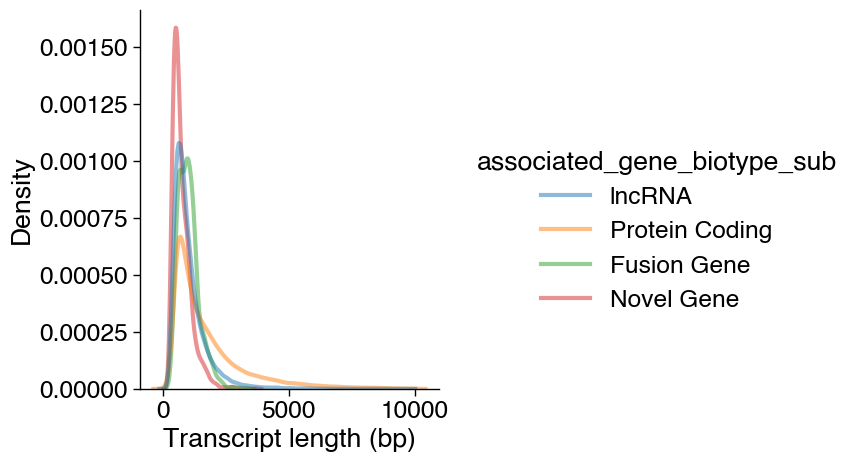

In [8]:
temp = mt_df[['length', 'isoform', 'associated_gene_biotype_sub']].drop_duplicates()
temp = temp.loc[temp.length<10000]
init_plot_settings()
ax = sns.displot(temp,
                 x='length', kind='kde',
                 hue='associated_gene_biotype_sub',
                 linewidth=3, common_norm=False, alpha=0.5)
ax.set(xlabel='Transcript length (bp)')


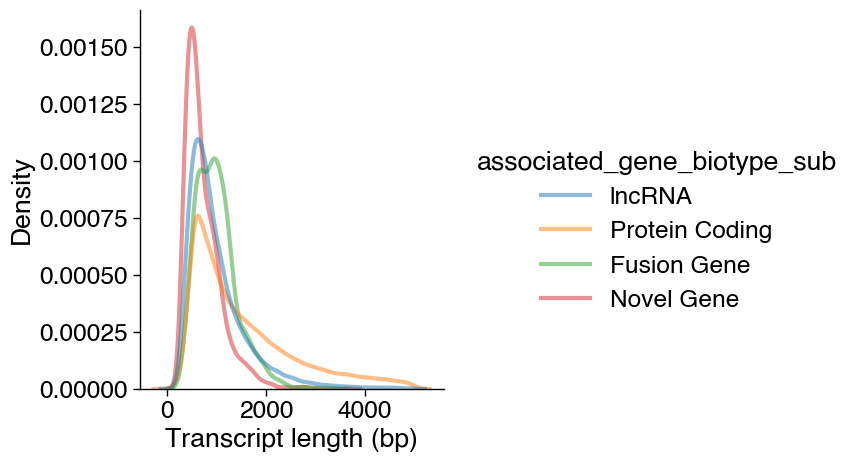

In [9]:
temp = mt_df[['length', 'isoform', 'associated_gene_biotype_sub']].drop_duplicates()
temp = temp.loc[temp.length<5000]
init_plot_settings()
ax = sns.displot(temp,
                 x='length', kind='kde',
                 hue='associated_gene_biotype_sub',
                 linewidth=3, common_norm=False, alpha=0.5)
ax.set(xlabel='Transcript length (bp)')


[Text(0, 0.5, 'Transcript length (bp)'), Text(0.5, 0, '')]

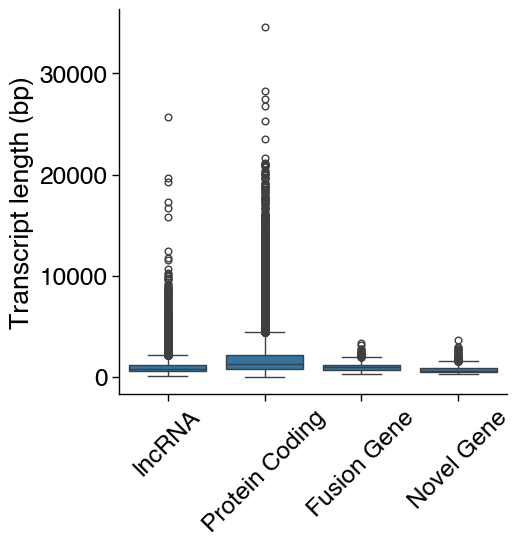

In [10]:
init_plot_settings(aspect='square')
ax = sns.boxplot(mt_df,
                 y='length',
                 x='associated_gene_biotype_sub')
clean_figure(ax)
ax.set(ylabel='Transcript length (bp)', xlabel='')

[Text(0, 0.5, 'Transcript length (bp)'), Text(0.5, 0, '')]

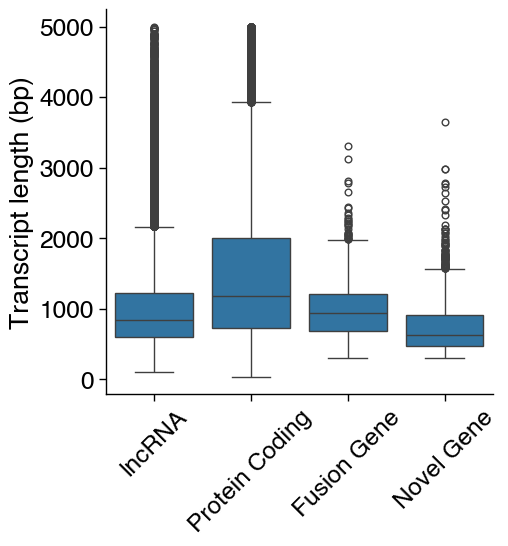

In [11]:
temp = temp.loc[temp.length<5000]

init_plot_settings(aspect='square')
ax = sns.boxplot(temp,
                 y='length',
                 x='associated_gene_biotype_sub')
clean_figure(ax)
ax.set(ylabel='Transcript length (bp)', xlabel='')

## Split by known / novel / promoted ISM

In [12]:
uma_mt = pd.read_csv('../supp_tables/02_uma_mt.tsv', sep='\t')

# promoted genes are those that are FSMs in poder
# but not present in uma 
promoted_fsm_ids = list(set(mt_df.loc[mt_df.structural_category=='FSM'].isoform.tolist()) -\
                   set(uma_mt.loc[uma_mt.structural_category=='FSM']['isoform']))

mt_df['gene_len_nov'] = np.nan
mt_df.loc[mt_df.structural_category=='FSM', 'gene_len_nov'] = 'FSM'
mt_df.loc[mt_df.structural_category!='FSM', 'gene_len_nov'] = 'Novel'
mt_df.loc[mt_df.isoform.isin(promoted_fsm_ids), 'gene_len_nov'] ='FSM (Promoted ISM)'

assert len(promoted_fsm_ids) == 10255
# got the number from the paper

/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_57872/1198940021.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'FSM' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


## How long are the transcripts from these novelty designations?

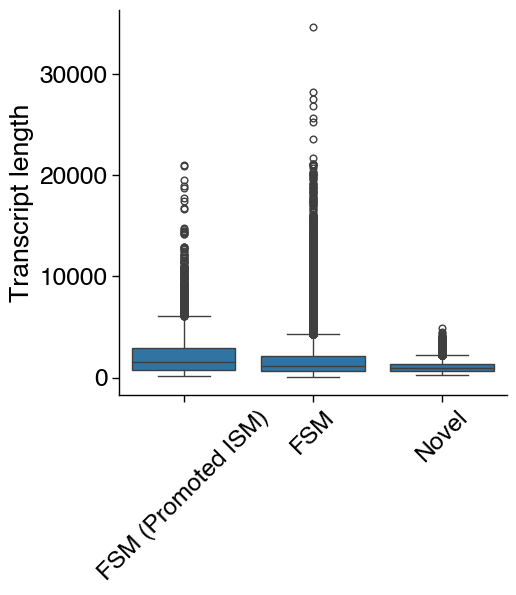

In [13]:
init_plot_settings(aspect='square')
ax = sns.boxplot(mt_df,
                 y='length',
                 x='gene_len_nov')
ax.set(ylabel='Transcript length', xlabel='')
clean_figure(ax)

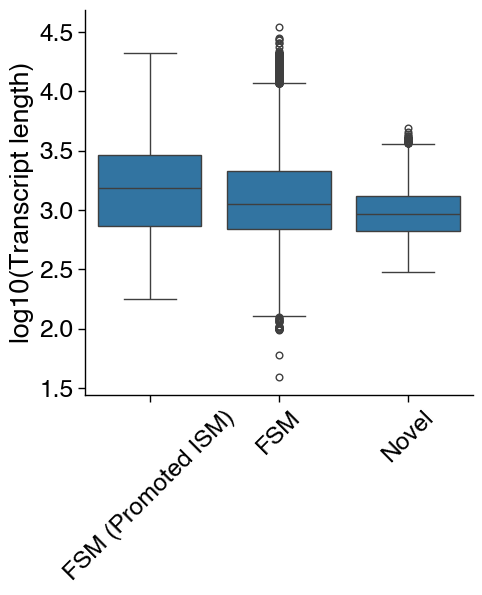

In [17]:
# logged version
init_plot_settings(aspect='square')
mt_df['log10_t_len'] = np.log10(mt_df['length'])
ax = sns.boxplot(mt_df,
                 y='log10_t_len',
                 x='gene_len_nov')
ax.set(ylabel='log10(Transcript length)', xlabel='')
clean_figure(ax)

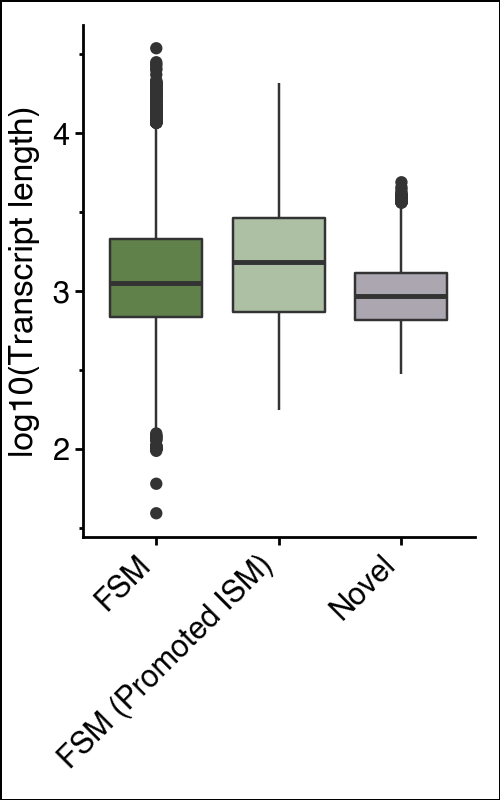

In [24]:
# plotnine equivalent
c_dict, order = get_novelty_colors(mt_df.gene_len_nov.unique().tolist())
c_dict['FSM (Promoted ISM)'] = '#adc0a4'
c_dict['Novel'] = '#aca6b0'
(
    ggplot(mt_df, aes(x='gene_len_nov', y='log10_t_len', fill='gene_len_nov'))
    + geom_boxplot()
    + scale_fill_manual(c_dict)
    + labs(
        y='log10(Transcript length)',
        x='')
    + my_theme(w=2.5, h=4)
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1))
    + theme(legend_position='none')
)

In [15]:
# well, they look different but also let's check 
import itertools
for s in list(itertools.combinations(mt_df.gene_len_nov.unique().tolist(), 2)):
    x = mt_df.loc[mt_df.gene_len_nov==s[0], 'length'].tolist()
    y = mt_df.loc[mt_df.gene_len_nov==s[1], 'length'].tolist()
    stat, pval = st.mannwhitneyu(x, y)
    # print(f'{s[0]} vs {s[1]}')
    print(f'{s[0]} median: {np.median(x)}')
    print(f'{s[1]} median: {np.median(y)}')
    print(stat)
    print(pval)
    print()

FSM (Promoted ISM) median: 1522.0
FSM median: 1132.0
604389402.5
9.188744553525494e-105

FSM (Promoted ISM) median: 1522.0
Novel median: 934.0
282913858.0
0.0

FSM median: 1132.0
Novel median: 934.0
2602880063.0
0.0



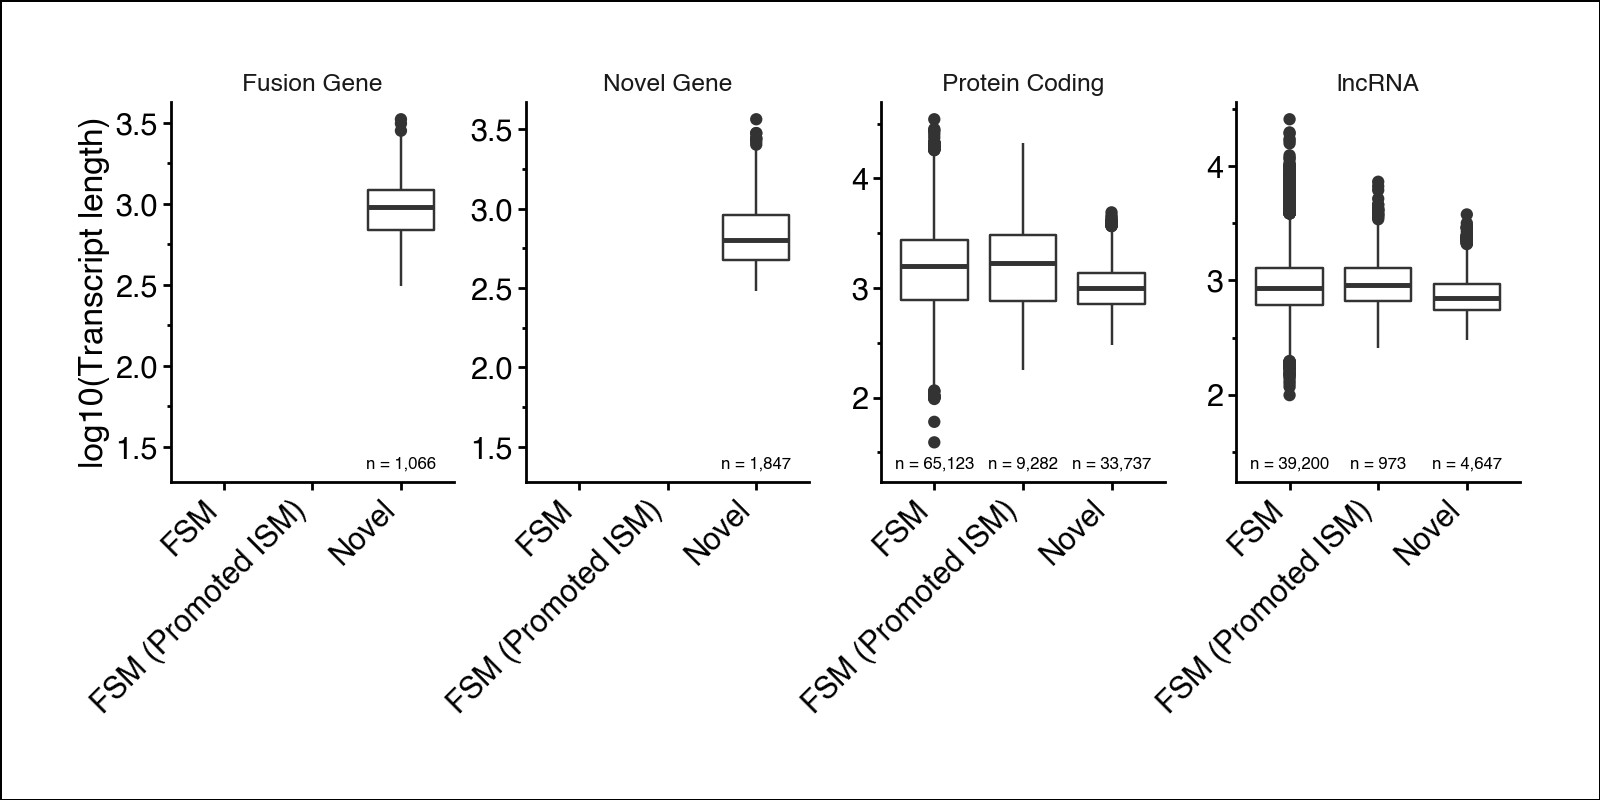

In [16]:
# plotnine version faceted by gene biotype

# 1. Count n per gene_len_nov per facet
n_labels = (
    mt_df.groupby(['associated_gene_biotype_sub', 'gene_len_nov'])
    .size()
    .reset_index(name='n')
)

# 2. Format label
n_labels['label'] = 'n = ' + n_labels['n'].apply(lambda x: f"{x:,}")

# 2. Set fixed y-position below boxes
y_min = mt_df['log10_t_len'].min()
n_labels['y'] = y_min - 0.2  # tweak -0.2 as needed to move lower


(
    ggplot(mt_df, aes(x='gene_len_nov', y='log10_t_len'))
    + geom_boxplot()
    + facet_wrap('~associated_gene_biotype_sub',
                 ncol=len(mt_df.associated_gene_biotype_sub.unique().tolist()),
                 scales='free_y')  # Adjust ncol as needed
    + labs(
        y='log10(Transcript length)',
        x=''
    )
    + geom_text(
        n_labels,
        aes(x='gene_len_nov', y='y', label='label'),
        inherit_aes=False,
        size=6  # increase for readability if needed
    )
    + my_theme(w=8, h=4)
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1))
)

In [17]:
# well, they look different but also let's check 
import itertools
for c in mt_df.associated_gene_biotype_sub.unique().tolist():
    temp = mt_df.loc[mt_df.associated_gene_biotype_sub==c]
    for s in list(itertools.combinations(mt_df.gene_len_nov.unique().tolist(), 2)):
        x = temp.loc[temp.gene_len_nov==s[0], 'length'].tolist()
        y = temp.loc[temp.gene_len_nov==s[1], 'length'].tolist()
        stat, pval = st.mannwhitneyu(x, y)
        # print(f'{s[0]} vs {s[1]}')
        print(c)
        print(f'{s[0]} median: {np.median(x)}')
        print(f'{s[1]} median: {np.median(y)}')
        print(stat)
        print(pval)
        print()

lncRNA
FSM (Promoted ISM) median: 917.0
FSM median: 858.0
20200196.0
0.0015746311061046166

lncRNA
FSM (Promoted ISM) median: 917.0
Novel median: 704.0
2970476.0
1.1762196813750227e-53

lncRNA
FSM median: 858.0
Novel median: 704.0
112547905.0
1.4023743340494878e-152

Protein Coding
FSM (Promoted ISM) median: 1703.0
FSM median: 1571.0
310391261.0
2.525054498281801e-05

Protein Coding
FSM (Promoted ISM) median: 1703.0
Novel median: 994.0
208885016.5
0.0

Protein Coding
FSM median: 1571.0
Novel median: 994.0
1462207261.5
0.0

Fusion Gene
FSM (Promoted ISM) median: nan
FSM median: nan
nan
nan

Fusion Gene
FSM (Promoted ISM) median: nan
Novel median: 947.0
nan
nan

Fusion Gene
FSM median: nan
Novel median: 947.0
nan
nan

Novel Gene
FSM (Promoted ISM) median: nan
FSM median: nan
nan
nan

Novel Gene
FSM (Promoted ISM) median: nan
Novel median: 630.0
nan
nan

Novel Gene
FSM median: nan
Novel median: 630.0
nan
nan



/var/folders/ch/bc1lrgbd1fn_3gxz886mxjz00000gn/T/ipykernel_49083/370727173.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide


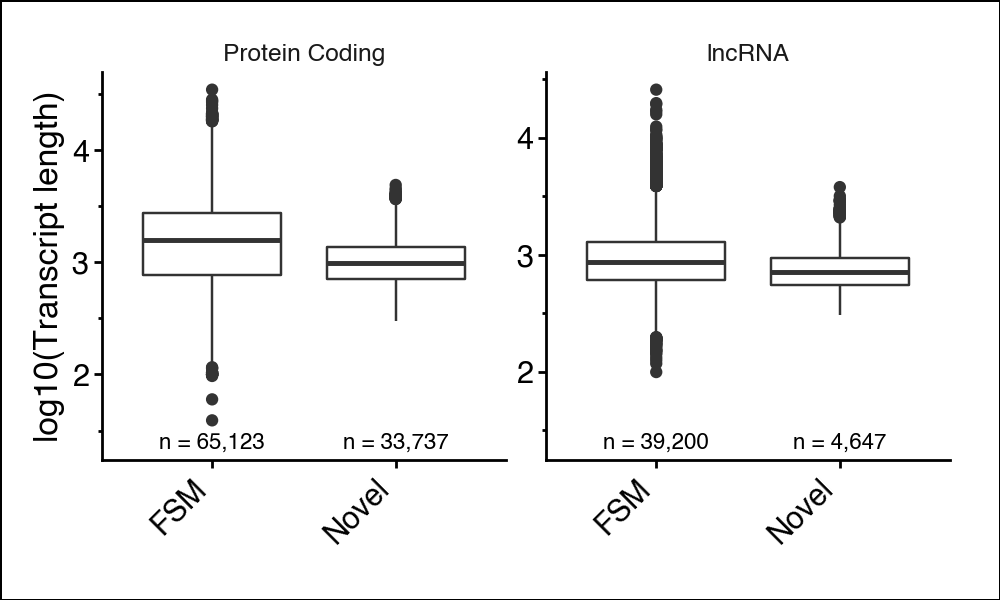

In [18]:
# limit just to pc and lnc, and just to novel vs. fsm
temp = mt_df.loc[(mt_df.associated_gene_biotype_sub.isin(['Protein Coding', 'lncRNA']))&\
                 (mt_df.gene_len_nov.isin(['Novel', 'FSM']))]

# plotnine version faceted by gene biotype

# 1. Count n per gene_len_nov per facet
n_labels = (
    temp.groupby(['associated_gene_biotype_sub', 'gene_len_nov'])
    .size()
    .reset_index(name='n')
)

# 2. Format label
n_labels['label'] = 'n = ' + n_labels['n'].apply(lambda x: f"{x:,}")

# 2. Set fixed y-position below boxes
y_min = temp['log10_t_len'].min()
n_labels['y'] = y_min - 0.2  # tweak -0.2 as needed to move lower


(
    ggplot(temp, aes(x='gene_len_nov', y='log10_t_len'))
    + geom_boxplot()
    + facet_wrap('~associated_gene_biotype_sub',
                 ncol=len(temp.associated_gene_biotype_sub.unique().tolist()),
                 scales='free_y')  # Adjust ncol as needed
    + labs(
        y='log10(Transcript length)',
        x=''
    )
    + geom_text(
        n_labels,
        aes(x='gene_len_nov', y='y', label='label'),
        inherit_aes=False,
        size=8  # increase for readability if needed
    )
    + my_theme(w=5, h=3)
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1))
)

In [19]:
# well, they look different but also let's check 
import itertools
for c in temp.associated_gene_biotype_sub.unique().tolist():
    temp2 = temp.loc[temp.associated_gene_biotype_sub==c]
    for s in list(itertools.combinations(temp.gene_len_nov.unique().tolist(), 2)):
        x = temp2.loc[temp.gene_len_nov==s[0], 'length'].tolist()
        y = temp2.loc[temp.gene_len_nov==s[1], 'length'].tolist()
        stat, pval = st.mannwhitneyu(x, y)
        # print(f'{s[0]} vs {s[1]}')
        print(c)
        print(f'{s[0]} median: {np.median(x)}')
        print(f'{s[1]} median: {np.median(y)}')
        print(stat)
        print(pval)
        print()

lncRNA
FSM median: 858.0
Novel median: 704.0
112547905.0
1.4023743340494878e-152

Protein Coding
FSM median: 1571.0
Novel median: 994.0
1462207261.5
0.0



## Correlate transcript expression w/ transcript length

In [20]:
# read in the expression matrix
f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.head()
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
df.set_index('tid', inplace=True)

In [21]:
# get max. expression per transcript 
drop_cols = df.columns.tolist()
df['max_tpm'] = df.max(axis=1)
df = df.drop(drop_cols, axis=1)
df.head()

,max_tpm
tid,
ENST00000413811.3,0.000000
transcript_6675,1.204920
transcript_6676,1.738870
transcript_6684,1.756230
transcript_6687,0.247031


In [22]:
# merge in max exp. w/ mt_df
mt_df = mt_df.merge(df, 
                    how='left',
                    left_on='isoform',
                    right_index=True)
mt_df['log10_max_tpm'] = np.log10(mt_df['max_tpm']+1)

In [23]:
def plot_thing(df, c1, c2, hue, c_dict):

        ax = sns.jointplot(data=df, x=c1, y=c2,
                             hue=hue, palette=c_dict,
                             # xlim=(0,xlim), ylim=(0,ylim), 
                             joint_kws={'data':df, 's':40, 'alpha':0.4})
        ax = ax.ax_joint
        
        # plot regression lines and equation of regression lines
        # https://stackoverflow.com/questions/48145924/different-colors-for-points-and-line-in-seaborn-regplot/68135585#68135585
        # https://stackoverflow.com/questions/45902739/seaborn-annotate-the-linear-regression-equation
        # https://stackoverflow.com/questions/62705904/add-entry-to-matplotlib-legend-without-plotting-an-object
        lines = []
        labels = []
        for s in df[hue].unique().tolist():
            temp = df.loc[df[hue] == s]
            color = c_dict[s]
            line_color = adjust_lightness(color, 0.5)
            
            # get coeffs of linear fit
            slope, intercept, r_value, p_value, std_err = stats.linregress(temp[c1],temp[c2])
            lines += [mpl.lines.Line2D([0], [0], color=line_color)]
            labels += ['m={0:.1f}'.format(slope)]
    
            print('Slope of {} correlation: {}'.format(s, slope))
            print(f'Pval = {p_value}')
            print(f'n = {len(temp.index)}')
            
            
            sns.regplot(data=temp, x=c1, y=c2,
                        scatter=False, ax=ax, color=color)
            sns.regplot(data=temp, x=c1, y=c2,
                scatter=False, ax=ax, color=color, ci=0,
                line_kws={'color':line_color,
                          'linestyle':'-',
                          'label':"m={0:.1f}".format(slope)})
        
        ax.legend(title='')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # ax.get_legend().remove()

        _ = ax.set(xlabel='log10(Transcript length)', ylabel='Log10(Max. transcript TPM+1)')

Slope of lncRNA correlation: 0.13185097119170913
Pval = 8.660039943077474e-188
n = 44820
Slope of Protein Coding correlation: 0.302966723397023
Pval = 0.0
n = 108142
Slope of Fusion Gene correlation: 1.1829981042967885
Pval = 3.126962518114456e-14
n = 1066
Slope of Novel Gene correlation: 0.33874707328457015
Pval = 5.3143942113289936e-20
n = 1847


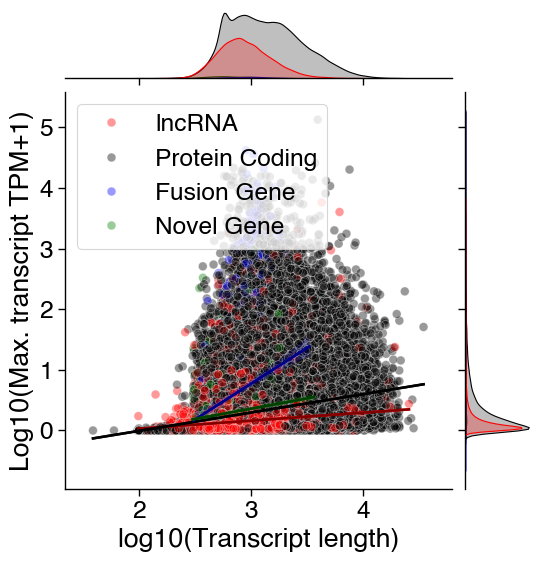

In [24]:
# plot and correlate transcript length w/ max. expression; split by gene biotype
c_dict = {'Protein Coding': 'k', 
      'Fusion Gene': 'b',
      'lncRNA': 'r', 
      'Novel Gene': 'g'}
plot_thing(mt_df, 'log10_t_len', 'log10_max_tpm', 'associated_gene_biotype_sub', c_dict)

Slope of FSM correlation: 0.38256575029804973
Pval = 0.0
n = 114578
Slope of NNC correlation: 0.0661420942652188
Pval = 8.316326065952197e-09
n = 20959
Slope of Fusion correlation: 1.1829981042967885
Pval = 3.126962518114456e-14
n = 1066
Slope of NIC correlation: 0.25704557668196004
Pval = 6.009198289526216e-112
n = 17425
Slope of Antisense correlation: 0.2658107157368587
Pval = 1.2341604440137294e-12
n = 1002
Slope of Intergenic correlation: 0.2530116768079472
Pval = 8.917058613003268e-07
n = 731
Slope of Genic correlation: 1.5981559364157703
Pval = 1.505064356838954e-05
n = 114


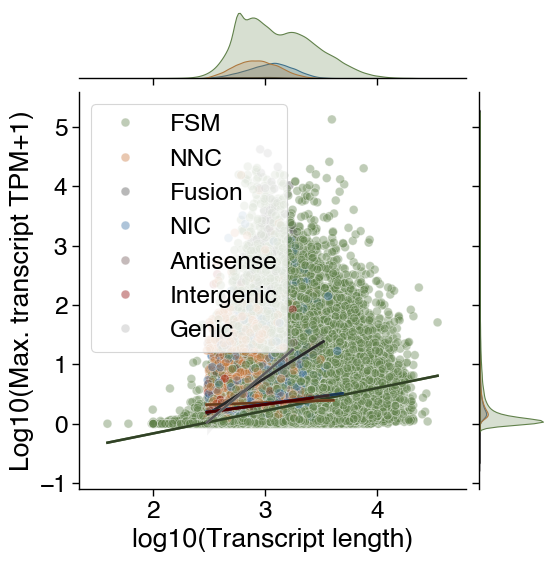

In [25]:
# plot and correlate transcript length w/ max. expression; split by transcript novelty
c_dict, order = get_novelty_colors(mt_df.structural_category.unique().tolist())
plot_thing(mt_df, 'log10_t_len', 'log10_max_tpm', 'structural_category', c_dict)


In [26]:
# maybe summarize these correlations in a bar plot because it's neater
hue = 'structural_category'
c1 = 'log10_t_len'
c2 = 'log10_max_tpm'
slopes = []
for s in mt_df[hue].unique().tolist():
    temp = mt_df.loc[mt_df[hue] == s]
    
    # get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(temp[c1],temp[c2])
    slopes += [slope]

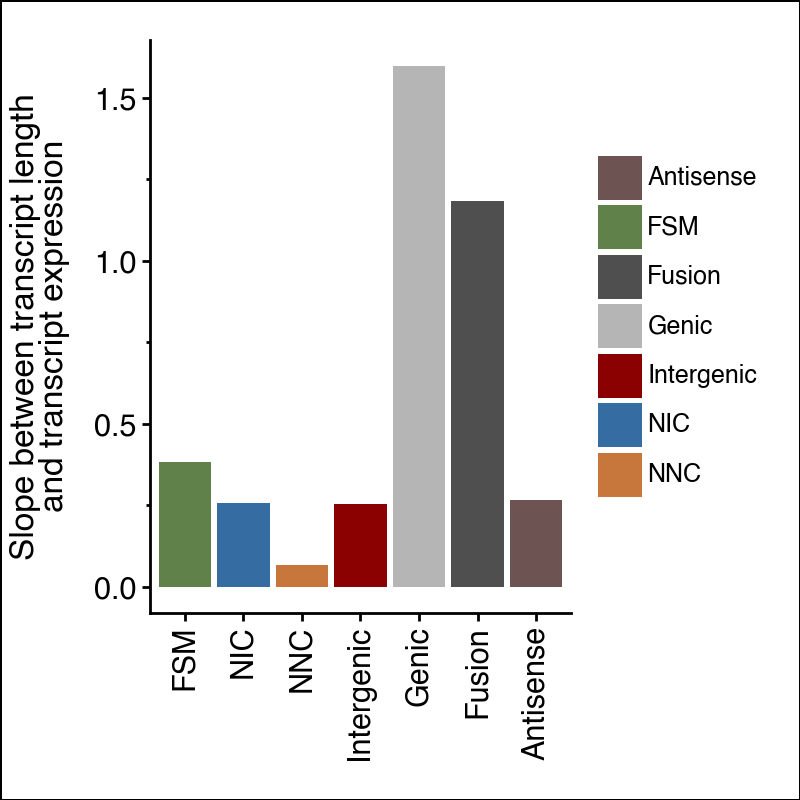

In [27]:
temp = pd.DataFrame({'slope': slopes, 
                     hue: mt_df[hue].unique().tolist()})

(ggplot(temp, aes(x='structural_category', y='slope', fill='structural_category'))
 +geom_bar(stat='identity')
 +scale_fill_manual(values=c_dict)
 +scale_x_discrete(limits=order)
 +my_theme(h=4)
 +labs(y='Slope between transcript length\nand transcript expression',
       x='')
 +theme(
    axis_text_x=element_text(rotation=90))
)

In [28]:
# maybe pearson or spearman correlation would be better actually
# maybe summarize these correlations in a bar plot because it's neater
hue = 'structural_category'
c1 = 'log10_t_len'
c2 = 'log10_max_tpm'
pearsons = []
spearmans = []
for s in mt_df[hue].unique().tolist():
    temp = mt_df.loc[mt_df[hue] == s]
    
    # get correlations
    x = temp[c1].tolist()
    y = temp[c2].tolist()
    r, r_p = st.pearsonr(x, y)
    rho, rho_p = st.spearmanr(x, y)

    pearsons.append(r)
    spearmans.append(rho)

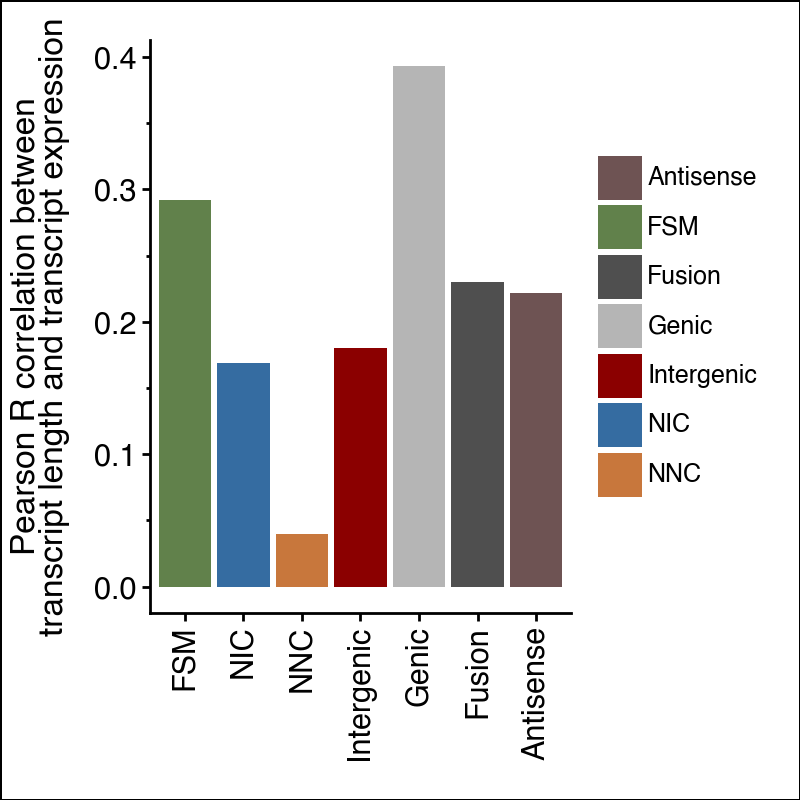

In [29]:
temp = pd.DataFrame({'pearson': pearsons, 
                     hue: mt_df[hue].unique().tolist()})
(ggplot(temp, aes(x='structural_category', y='pearson', fill='structural_category'))
 +geom_bar(stat='identity')
 +scale_fill_manual(values=c_dict)
 +scale_x_discrete(limits=order)
 +my_theme(h=4)
 +labs(y='Pearson R correlation between\ntranscript length and transcript expression',
       x='')
 +theme(
    axis_text_x=element_text(rotation=90))
)

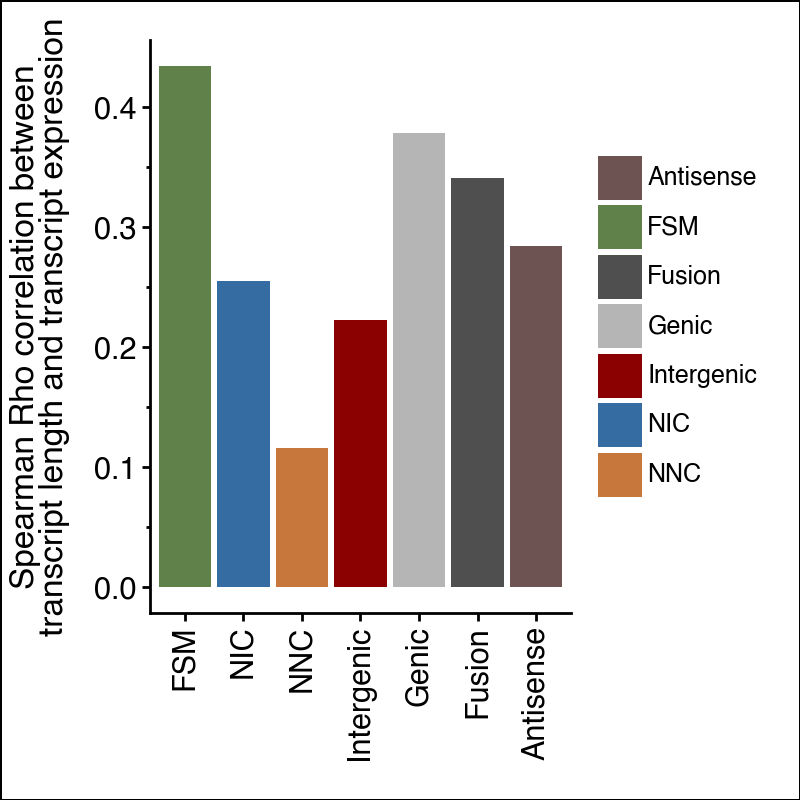

In [30]:
temp = pd.DataFrame({'spearman': spearmans, 
                     hue: mt_df[hue].unique().tolist()})
(ggplot(temp, aes(x='structural_category', y='spearman', fill='structural_category'))
 +geom_bar(stat='identity')
 +scale_fill_manual(values=c_dict)
 +scale_x_discrete(limits=order)
 +my_theme(h=4)
 +labs(y='Spearman Rho correlation between\ntranscript length and transcript expression',
       x='')
 +theme(
    axis_text_x=element_text(rotation=90))
)

## What if we use all samples' TPMs? 

In [31]:
# read in the expression matrix
f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.head()
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
df.set_index('tid', inplace=True)

In [32]:
samples = df.columns.tolist()

In [33]:
# drop the detection columns so we can merge in the TPM columns
mt_df = mt_df.drop(samples, axis=1)

# now merge
mt_df = mt_df.merge(df, how='left',
                    left_on='isoform',
                    right_index=True)

In [34]:

# log transform
log_tpm_cols = [f'{sample}_log10_tpm' for sample in samples]
mt_df[log_tpm_cols] = np.log10(mt_df[samples])
mt_df[log_tpm_cols] = mt_df[log_tpm_cols].replace(-np.inf, np.nan)  # or .where(df['tpm'] > 0)


/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10


In [35]:
# correlate,  make sure to ignore NaNs? 
hue = 'structural_category'
c1 = 'log10_t_len'

pearsons = []
spearmans = []
samples = []
novs = []

for c in log_tpm_cols:
    for s in mt_df[hue].unique().tolist():
        temp = mt_df.loc[mt_df[hue] == s]
        
        # get correlations for expressed transcripts only
        x = temp.loc[temp[c].notnull(), c1].tolist()
        y = temp.loc[temp[c].notnull(), c].tolist()
        r, r_p = st.pearsonr(x, y)
        rho, rho_p = st.spearmanr(x, y)
    
        pearsons.append(r)
        spearmans.append(rho)
        samples.append(c.split('_')[0])
        novs.append(s)

In [36]:
temp = pd.DataFrame({'pearson': pearsons, 
                     'spearman': spearmans,
                     'sample': samples,
                     hue: novs})

In [37]:
p_c_dict, p_order = get_population_colors()
temp['population'] = temp['sample'].str.slice(0,3)

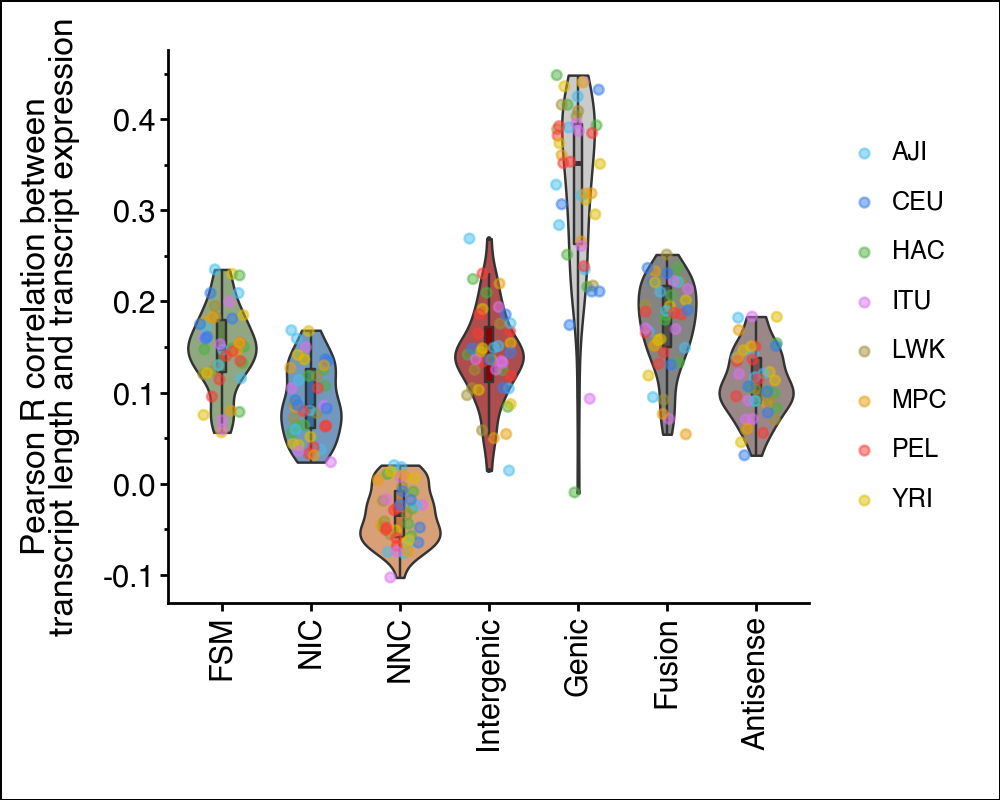

In [38]:
(ggplot(temp, aes(x='structural_category', y='pearson', fill='structural_category'))
 +geom_violin(alpha=0.7)
 +geom_boxplot(outlier_size=0, width=0.1)
 +geom_jitter(aes(fill='population', color='population'),
              size=1.5, alpha=0.5, width=0.25)
 +scale_color_manual(values=p_c_dict)
 +scale_fill_manual(values=c_dict|p_c_dict)
 +scale_x_discrete(limits=order)
 +my_theme(h=4, w=5)
 +theme(legend_box='horizontal')
 +guides(fill="none")
 +labs(y='Pearson R correlation between\ntranscript length and transcript expression',
       x='')
 +theme(
    axis_text_x=element_text(rotation=90))
)

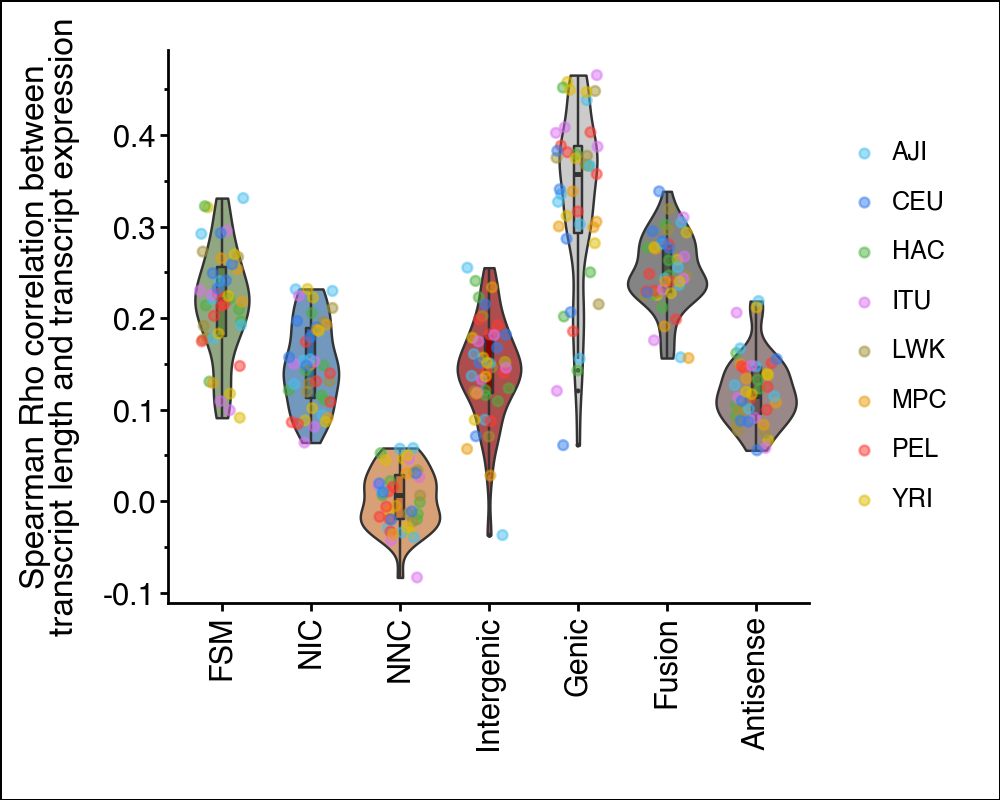

In [39]:
(ggplot(temp, aes(x='structural_category', y='spearman', fill='structural_category'))
 +geom_violin(alpha=0.7)
 +geom_boxplot(outlier_size=0, width=0.1)
 +geom_jitter(aes(fill='population', color='population'),
              size=1.5, alpha=0.5, width=0.25)
 +scale_color_manual(values=p_c_dict)
 +scale_fill_manual(values=c_dict|p_c_dict)
 +scale_x_discrete(limits=order)
 +my_theme(h=4, w=5)
 +theme(legend_box='horizontal')
 +guides(fill="none")
 +labs(y='Spearman Rho correlation between\ntranscript length and transcript expression',
       x='')
 +theme(
    axis_text_x=element_text(rotation=90))
)

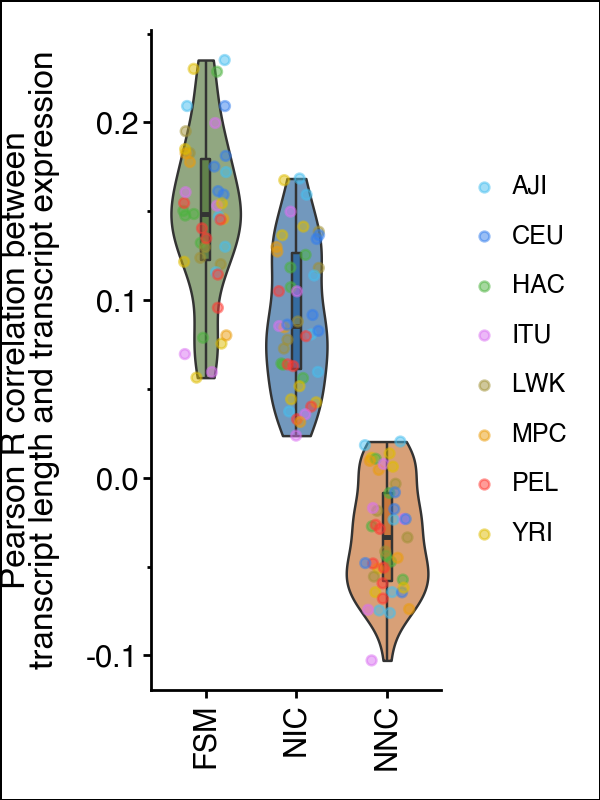

In [40]:
# ones I actually care about
temp2 = temp.loc[temp.structural_category.isin(['FSM', 'NIC', 'NNC'])]
c_dict, order = get_novelty_colors(temp2.structural_category.unique().tolist())
(ggplot(temp2, aes(x='structural_category', y='pearson', fill='structural_category'))
 +geom_violin(alpha=0.7)
 +geom_boxplot(outlier_size=0, width=0.1)
 +geom_jitter(aes(fill='population', color='population'),
              size=1.5, alpha=0.5, width=0.25)
 +scale_color_manual(values=p_c_dict)
 +scale_fill_manual(values=c_dict|p_c_dict)
 +scale_x_discrete(limits=order)
 +my_theme(h=4, w=3)
 +theme(legend_box='horizontal')
 +guides(fill="none")
 +labs(y='Pearson R correlation between\ntranscript length and transcript expression',
       x='')
 +theme(
    axis_text_x=element_text(rotation=90))
)

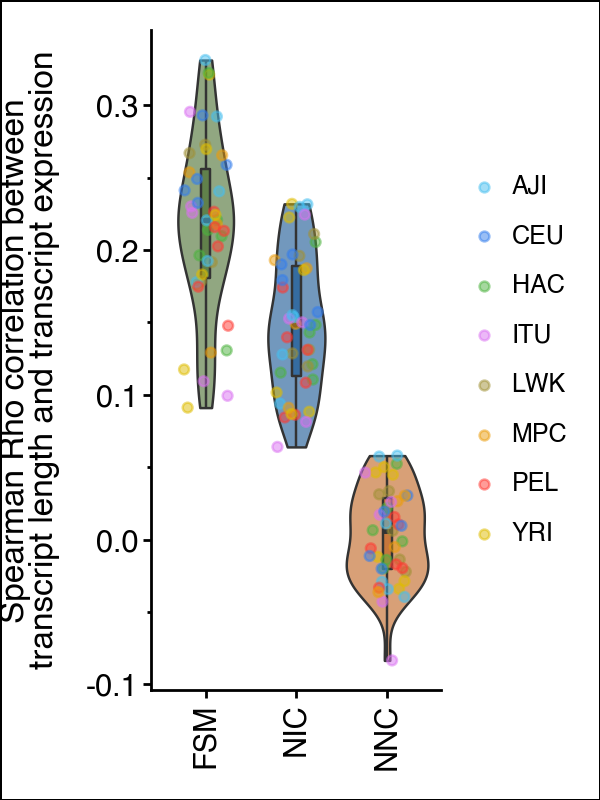

In [41]:
# ones I actually care about
temp2 = temp.loc[temp.structural_category.isin(['FSM', 'NIC', 'NNC'])]
c_dict, order = get_novelty_colors(temp2.structural_category.unique().tolist())
(ggplot(temp2, aes(x='structural_category', y='spearman', fill='structural_category'))
 +geom_violin(alpha=0.7)
 +geom_boxplot(outlier_size=0, width=0.1)
 +geom_jitter(aes(fill='population', color='population'),
              size=1.5, alpha=0.5, width=0.25)
 +scale_color_manual(values=p_c_dict)
 +scale_fill_manual(values=c_dict|p_c_dict)
 +scale_x_discrete(limits=order)
 +my_theme(h=4, w=3)
 +theme(legend_box='horizontal')
 +guides(fill="none")
 +labs(y='Spearman Rho correlation between\ntranscript length and transcript expression',
       x='')
 +theme(
    axis_text_x=element_text(rotation=90))
)

In [42]:
# well, they look different but also let's check 
import itertools
for s in list(itertools.combinations(temp2.structural_category.unique().tolist(), 2)):
    x = temp2.loc[temp2.structural_category==s[0], 'pearson'].tolist()
    y = temp2.loc[temp2.structural_category==s[1], 'pearson'].tolist()
    stat, pval = st.mannwhitneyu(x, y)
    # print(f'{s[0]} vs {s[1]}')
    print(f'{s[0]} median: {np.median(x)}')
    print(f'{s[1]} median: {np.median(y)}')
    print(stat)
    print(pval)
    print()

FSM median: 0.1484366295409667
NNC median: -0.03358333127413882
1849.0
1.4564603168028731e-15

FSM median: 0.1484366295409667
NIC median: 0.08539664633660354
1516.0
3.317359558983084e-07

NNC median: -0.03358333127413882
NIC median: 0.08539664633660354
0.0
1.4564603168028731e-15



In [43]:
# well, they look different but also let's check 
import itertools
for s in list(itertools.combinations(temp2.structural_category.unique().tolist(), 2)):
    x = temp2.loc[temp2.structural_category==s[0], 'spearman'].tolist()
    y = temp2.loc[temp2.structural_category==s[1], 'spearman'].tolist()
    stat, pval = st.mannwhitneyu(x, y)
    # print(f'{s[0]} vs {s[1]}')
    print(f'{s[0]} median: {np.median(x)}')
    print(f'{s[1]} median: {np.median(y)}')
    print(stat)
    print(pval)
    print()

FSM median: 0.22046762386955487
NNC median: 0.00614148157378121
1849.0
1.4564603168028731e-15

FSM median: 0.22046762386955487
NIC median: 0.14825021952865272
1485.0
1.320019601321231e-06

NNC median: 0.00614148157378121
NIC median: 0.14825021952865272
0.0
1.4564603168028731e-15



In [44]:
# so all of these are significantly different

## Transcript length distributions by novelty

In [45]:
mt_df.head()

,isoform,geneid.v,associated_gene_biotype,proteinv47_Chromosome,proteinv47_Start,proteinv47_Stop,proteinv47_Strand,proteinv47_Source,proteinv47_CDS_Source,proteinv47_CDS_Start,...,AJI6_log10_tpm,CEU1_log10_tpm,CEU2_log10_tpm,CEU3_log10_tpm,CEU4_log10_tpm,CEU5_log10_tpm,MPC4_log10_tpm,YRI1_log10_tpm,YRI2_log10_tpm,YRI3_log10_tpm
0,ENST00000741425.1,ENSG00000296732.1,lncRNA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,transcript_0,ENSG00000296732.1,lncRNA,GL000008.2,83369.0,130598.0,+,Cerberus,CPAT,83410.0,...,NaN,NaN,-2.426793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,transcript_1,ENSG00000296732.1,lncRNA,GL000008.2,83374.0,199915.0,+,Cerberus,CPAT,83410.0,...,NaN,NaN,-2.426793,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,transcript_10,ENSG00000296732.1,lncRNA,GL000008.2,83404.0,199887.0,+,Cerberus,CPAT,83410.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,transcript_11,ENSG00000296732.1,lncRNA,GL000008.2,83376.0,88830.0,+,Cerberus,CPAT,83410.0,...,NaN,NaN,-2.426793,NaN,NaN,NaN,NaN,NaN,NaN,NaN


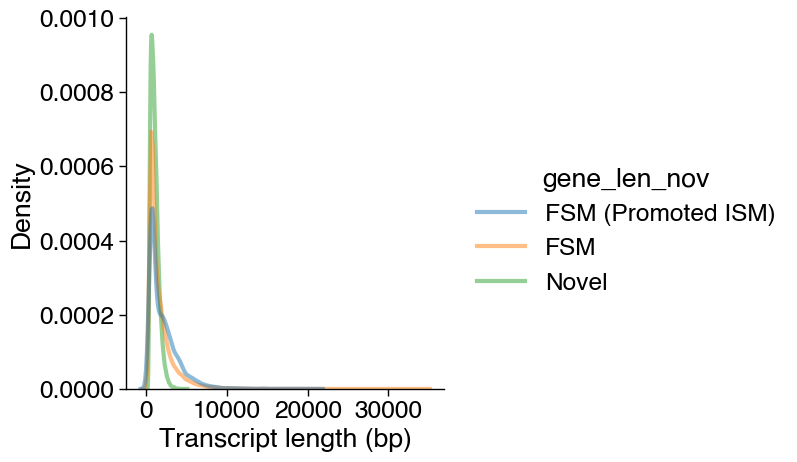

In [47]:
# biotype
temp = mt_df[['length', 'isoform', 'gene_len_nov']].drop_duplicates()
init_plot_settings()
ax = sns.displot(temp,
                 x='length', kind='kde',
                 hue='gene_len_nov',
                 linewidth=3, common_norm=False, alpha=0.5)
ax.set(xlabel='Transcript length (bp)')

## Transcript length to expression correlation by category (including promoted ISM)

In [69]:
# add new struct. cat. column 
mt_df['structural_category_2'] = mt_df.structural_category
mt_df.loc[mt_df.gene_len_nov=='FSM (Promoted ISM)', 'structural_category_2'] = 'FSM (Promoted ISM)'

c_dict, order = get_novelty_colors(mt_df.structural_category.unique().tolist())
c_dict['FSM - Promoted ISM'] = mute_color(c_dict['FSM'], factor=1.4)
order = [order[0]] + ['FSM (Promoted ISM)'] + order[1:]
order

['FSM',
 'FSM (Promoted ISM)',
 'NIC',
 'NNC',
 'Intergenic',
 'Genic',
 'Fusion',
 'Antisense']

In [70]:
# correlate,  make sure to ignore NaNs? 
hue = 'structural_category_2'
c1 = 'log10_t_len'

pearsons = []
spearmans = []
samples = []
novs = []

for c in log_tpm_cols:
    for s in mt_df[hue].unique().tolist():
        temp = mt_df.loc[mt_df[hue] == s]
        
        # get correlations for expressed transcripts only
        x = temp.loc[temp[c].notnull(), c1].tolist()
        y = temp.loc[temp[c].notnull(), c].tolist()
        r, r_p = st.pearsonr(x, y)
        rho, rho_p = st.spearmanr(x, y)
    
        pearsons.append(r)
        spearmans.append(rho)
        samples.append(c.split('_')[0])
        novs.append(s)

In [71]:
temp = pd.DataFrame({'pearson': pearsons, 
                     'spearman': spearmans,
                     'sample': samples,
                     hue: novs})

In [72]:
p_c_dict, p_order = get_population_colors()
temp['population'] = temp['sample'].str.slice(0,3)

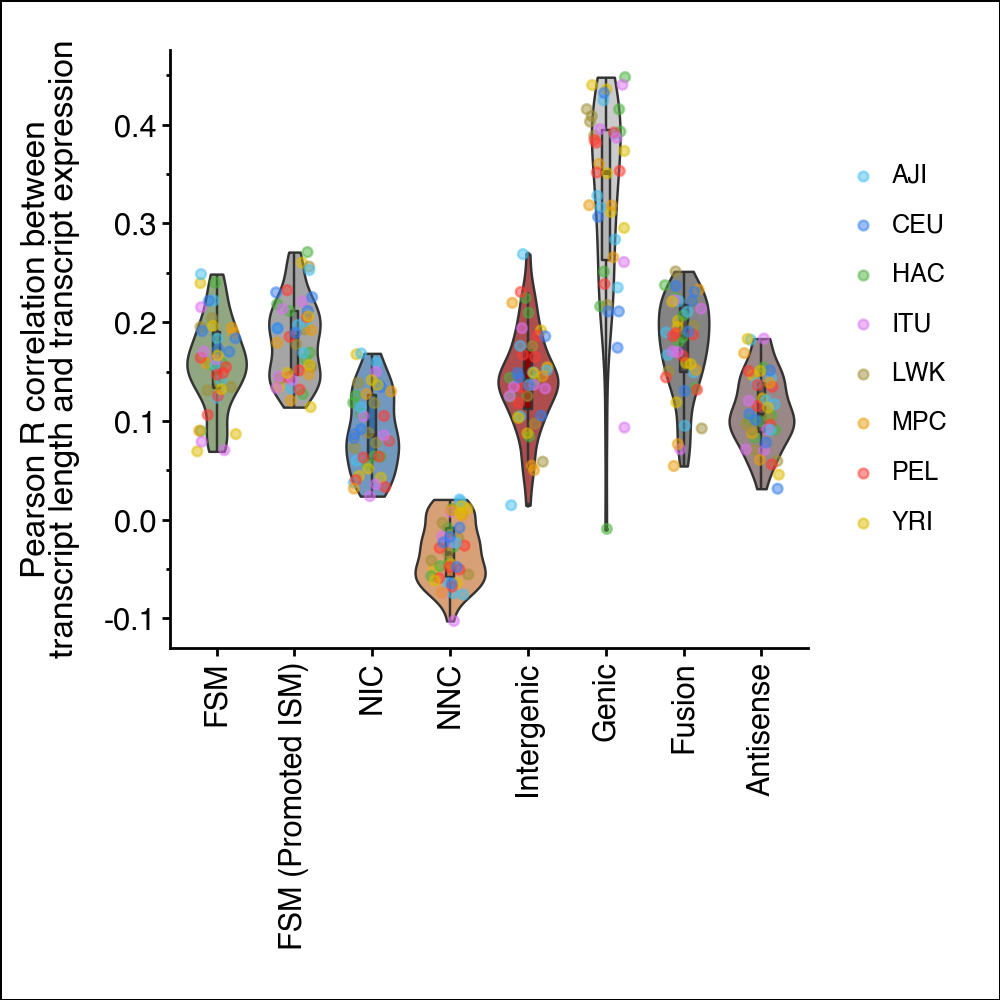

In [73]:
(ggplot(temp, aes(x='structural_category_2', y='pearson', fill='structural_category_2'))
 +geom_violin(alpha=0.7)
 +geom_boxplot(outlier_size=0, width=0.1)
 +geom_jitter(aes(fill='population', color='population'),
              size=1.5, alpha=0.5, width=0.25)
 +scale_color_manual(values=p_c_dict)
 +scale_fill_manual(values=c_dict|p_c_dict)
 +scale_x_discrete(limits=order)
 +my_theme(h=5, w=5)
 +theme(legend_box='horizontal')
 +guides(fill="none")
 +labs(y='Pearson R correlation between\ntranscript length and transcript expression',
       x='')
 +theme(
    axis_text_x=element_text(rotation=90))
)

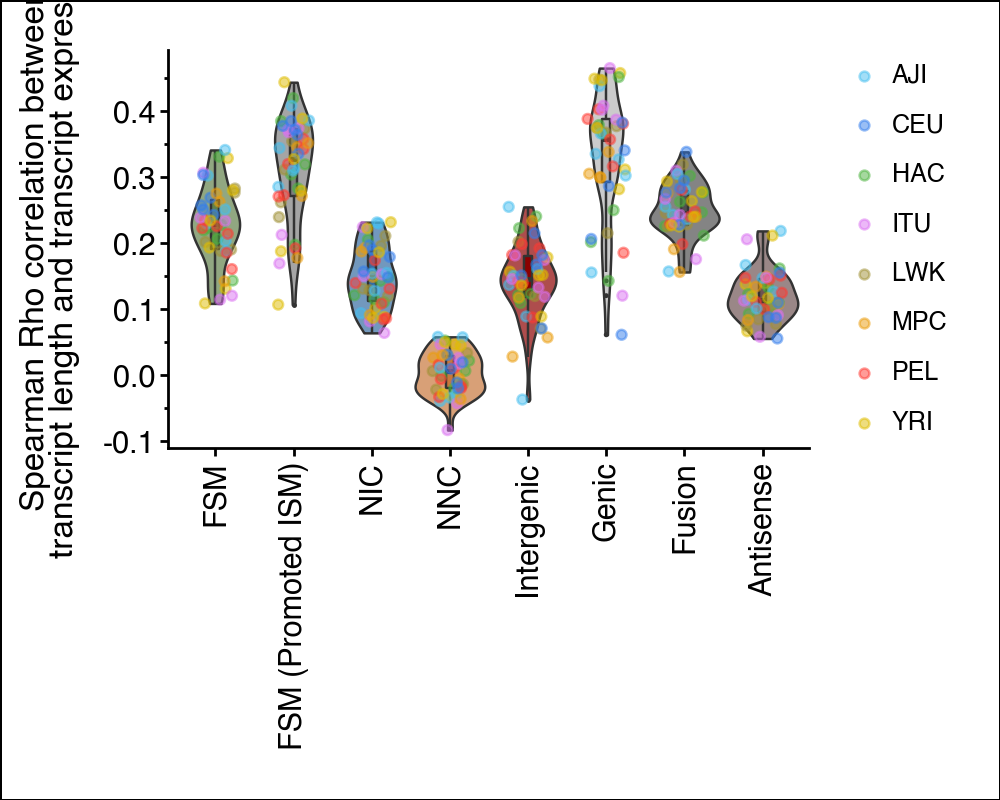

In [75]:
(ggplot(temp, aes(x='structural_category_2', y='spearman', fill='structural_category_2'))
 +geom_violin(alpha=0.7)
 +geom_boxplot(outlier_size=0, width=0.1)
 +geom_jitter(aes(fill='population', color='population'),
              size=1.5, alpha=0.5, width=0.25)
 +scale_color_manual(values=p_c_dict)
 +scale_fill_manual(values=c_dict|p_c_dict)
 +scale_x_discrete(limits=order)
 +my_theme(h=4, w=5)
 +theme(legend_box='horizontal')
 +guides(fill="none")
 +labs(y='Spearman Rho correlation between\ntranscript length and transcript expression',
       x='')
 +theme(
    axis_text_x=element_text(rotation=90))
)

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/scales/scale_manual.py:44: PlotnineWarning: The palette of scale_fill_manual can return a maximum of 11 values. 12 were requested from it.


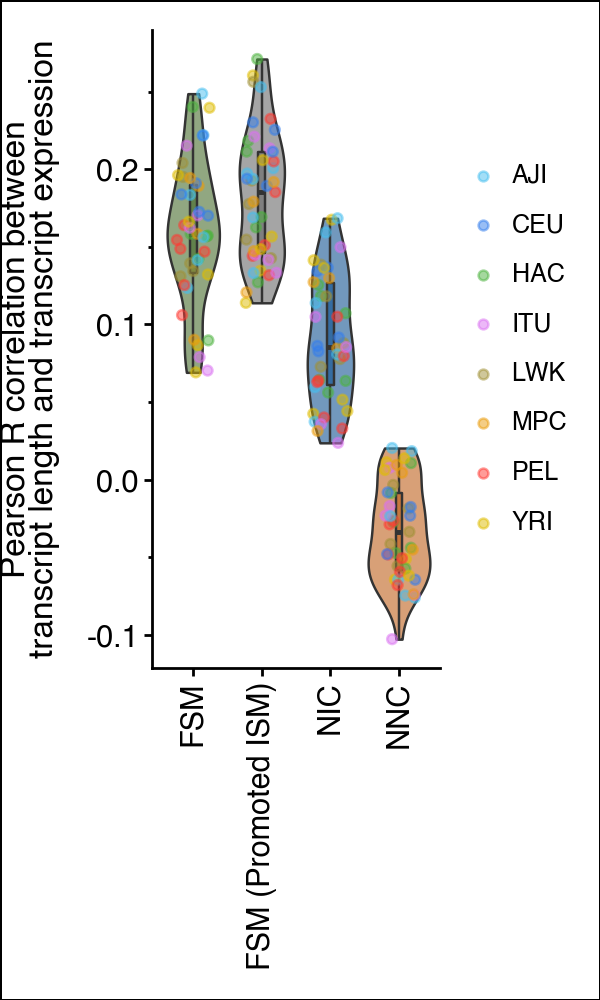

In [82]:
# ones I actually care about
cats = ['FSM', 'FSM (Promoted ISM)', 'NIC', 'NNC']
temp2 = temp.loc[temp.structural_category_2.isin(cats)]
c_dict, order = rm_color_cats(c_dict, order, cats)
(ggplot(temp2, aes(x='structural_category_2', y='pearson', fill='structural_category_2'))
 +geom_violin(alpha=0.7)
 +geom_boxplot(outlier_size=0, width=0.1)
 +geom_jitter(aes(fill='population', color='population'),
              size=1.5, alpha=0.5, width=0.25)
 +scale_color_manual(values=p_c_dict)
 +scale_fill_manual(values=c_dict|p_c_dict)
 +scale_x_discrete(limits=order)
 +my_theme(h=5, w=3)
 +theme(legend_box='horizontal')
 +guides(fill="none")
 +labs(y='Pearson R correlation between\ntranscript length and transcript expression',
       x='')
 +theme(
    axis_text_x=element_text(rotation=90))
)

/Users/fairliereese/miniconda3/envs/plotnine_test/lib/python3.12/site-packages/plotnine/scales/scale_manual.py:44: PlotnineWarning: The palette of scale_fill_manual can return a maximum of 11 values. 12 were requested from it.


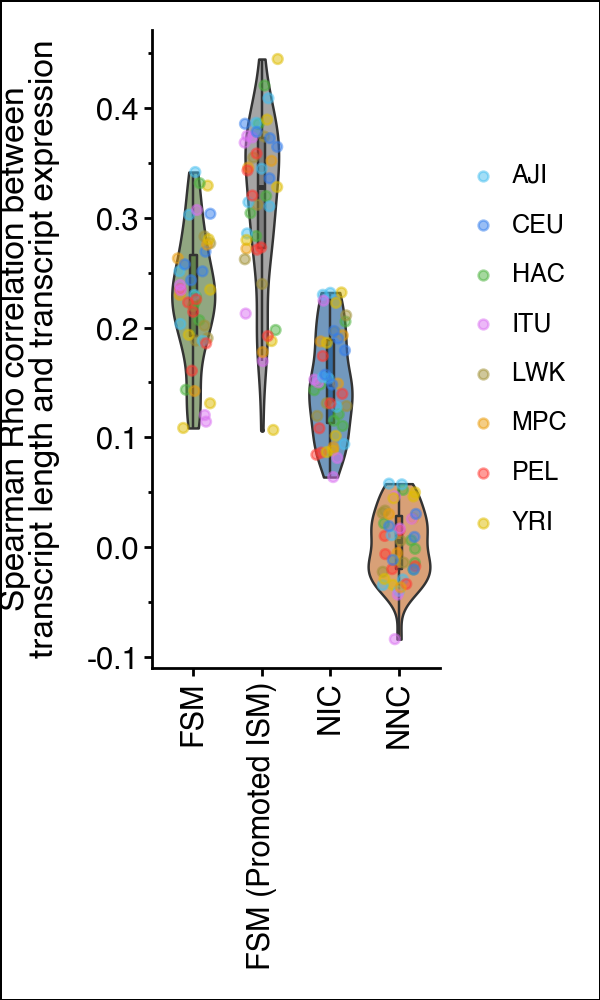

In [83]:
# ones I actually care about
# ones I actually care about
cats = ['FSM', 'FSM (Promoted ISM)', 'NIC', 'NNC']
temp2 = temp.loc[temp.structural_category_2.isin(cats)]
c_dict, order = rm_color_cats(c_dict, order, cats)
(ggplot(temp2, aes(x='structural_category_2', y='spearman', fill='structural_category_2'))
 +geom_violin(alpha=0.7)
 +geom_boxplot(outlier_size=0, width=0.1)
 +geom_jitter(aes(fill='population', color='population'),
              size=1.5, alpha=0.5, width=0.25)
 +scale_color_manual(values=p_c_dict)
 +scale_fill_manual(values=c_dict|p_c_dict)
 +scale_x_discrete(limits=order)
 +my_theme(h=5, w=3)
 +theme(legend_box='horizontal')
 +guides(fill="none")
 +labs(y='Spearman Rho correlation between\ntranscript length and transcript expression',
       x='')
 +theme(
    axis_text_x=element_text(rotation=90))
)

In [80]:
# well, they look different but also let's check 
import itertools
for s in list(itertools.combinations(temp2.structural_category_2.unique().tolist(), 2)):
    x = temp2.loc[temp2.structural_category_2==s[0], 'pearson'].tolist()
    y = temp2.loc[temp2.structural_category_2==s[1], 'pearson'].tolist()
    stat, pval = st.mannwhitneyu(x, y)
    # print(f'{s[0]} vs {s[1]}')
    print(f'{s[0]} median: {np.median(x)}')
    print(f'{s[1]} median: {np.median(y)}')
    print(stat)
    print(pval)
    print()

FSM (Promoted ISM) median: 0.1852656327202865
FSM median: 0.15836601333096856
1166.0
0.03738677556218321

FSM (Promoted ISM) median: 0.1852656327202865
NNC median: -0.03358333127413882
1849.0
1.4564603168028731e-15

FSM (Promoted ISM) median: 0.1852656327202865
NIC median: 0.08539664633660354
1742.0
1.7084342145854084e-12

FSM median: 0.15836601333096856
NNC median: -0.03358333127413882
1849.0
1.4564603168028731e-15

FSM median: 0.15836601333096856
NIC median: 0.08539664633660354
1598.0
6.147466427102105e-09

NNC median: -0.03358333127413882
NIC median: 0.08539664633660354
0.0
1.4564603168028731e-15



In [81]:
# well, they look different but also let's check 
import itertools
for s in list(itertools.combinations(temp2.structural_category_2.unique().tolist(), 2)):
    x = temp2.loc[temp2.structural_category_2==s[0], 'spearman'].tolist()
    y = temp2.loc[temp2.structural_category_2==s[1], 'spearman'].tolist()
    stat, pval = st.mannwhitneyu(x, y)
    # print(f'{s[0]} vs {s[1]}')
    print(f'{s[0]} median: {np.median(x)}')
    print(f'{s[1]} median: {np.median(y)}')
    print(stat)
    print(pval)
    print()

FSM (Promoted ISM) median: 0.32775610708398234
FSM median: 0.22957104942189574
1507.0
4.989150075605799e-07

FSM (Promoted ISM) median: 0.32775610708398234
NNC median: 0.00614148157378121
1849.0
1.4564603168028731e-15

FSM (Promoted ISM) median: 0.32775610708398234
NIC median: 0.14825021952865272
1753.0
8.587865629092278e-13

FSM median: 0.22957104942189574
NNC median: 0.00614148157378121
1849.0
1.4564603168028731e-15

FSM median: 0.22957104942189574
NIC median: 0.14825021952865272
1562.0
3.760096137723837e-08

NNC median: 0.00614148157378121
NIC median: 0.14825021952865272
0.0
1.4564603168028731e-15

